# Análise de Precisão ETA para Modelagem

**Objetivo:** Identificar padrões em pedidos com atrasos grandes para melhorar o modelo preditivo de ETA.

**Critério de Atraso:** Pedidos com atraso ≥ 20 minutos (ou 15 minutos se houver poucos casos)

**Definido:** Análise de atraso sendo de 15 minutos, já que com 20 existiam poucos pedidos

**Metodologia:** 
- Análise exploratória de atrasos
- Identificação de padrões por variáveis categóricas e numéricas
- Correlações entre variáveis e magnitude dos atrasos
- Insights para feature engineering no modelo preditivo


## 1. Setup e Imports


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 2. Carregamento e Preparação dos Dados


In [58]:
# Carregar base limpa
df = pd.read_csv('tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print(f"Dimensões da base: {df.shape}")
print(f"Período dos dados: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())


Dimensões da base: (5000, 16)
Período dos dados: 2024-01-01 15:08:00 até 2024-12-31 21:27:00

Colunas disponíveis:
['macro_bairro', 'nome_cliente', 'bairro_destino', 'order_datetime', 'platform', 'order_mode', 'distance_km', 'tempo_preparo_minutos', 'status', 'eta_minutes_quote', 'actual_delivery_minutes', 'total_brl', 'classe_pedido', 'platform_commission_pct', 'num_itens', 'satisfacao_nivel']


In [59]:
# Converter datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

# Calcular atraso (diferença entre tempo real e eta)
df['atraso_minutos'] = df['actual_delivery_minutes'] - df['eta_minutes_quote']

df['hora_pedido'] = df['order_datetime'].dt.hour
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['mes'] = df['order_datetime'].dt.month
df['is_weekend'] = df['order_datetime'].dt.weekday >= 5

def categorizar_horario(hora):
    if 6 <= hora < 12:
        return 'Manhã (6h-12h)'
    elif 12 <= hora < 18:
        return 'Tarde (12h-18h)'
    elif 18 <= hora < 24:
        return 'Noite (18h-24h)'
    else:
        return 'Madrugada (0h-6h)'

df['faixa_horario'] = df['hora_pedido'].apply(categorizar_horario)

print("Dados preparados com sucesso!")
print(f"\nEstatísticas do atraso:")
print(df['atraso_minutos'].describe())


Dados preparados com sucesso!

Estatísticas do atraso:
count    5000.000000
mean       -7.914708
std         9.257372
min       -34.000000
25%       -14.300000
50%        -8.500000
75%        -2.200000
max        29.400000
Name: atraso_minutos, dtype: float64


## 3. Análise de Distribuição dos Atrasos


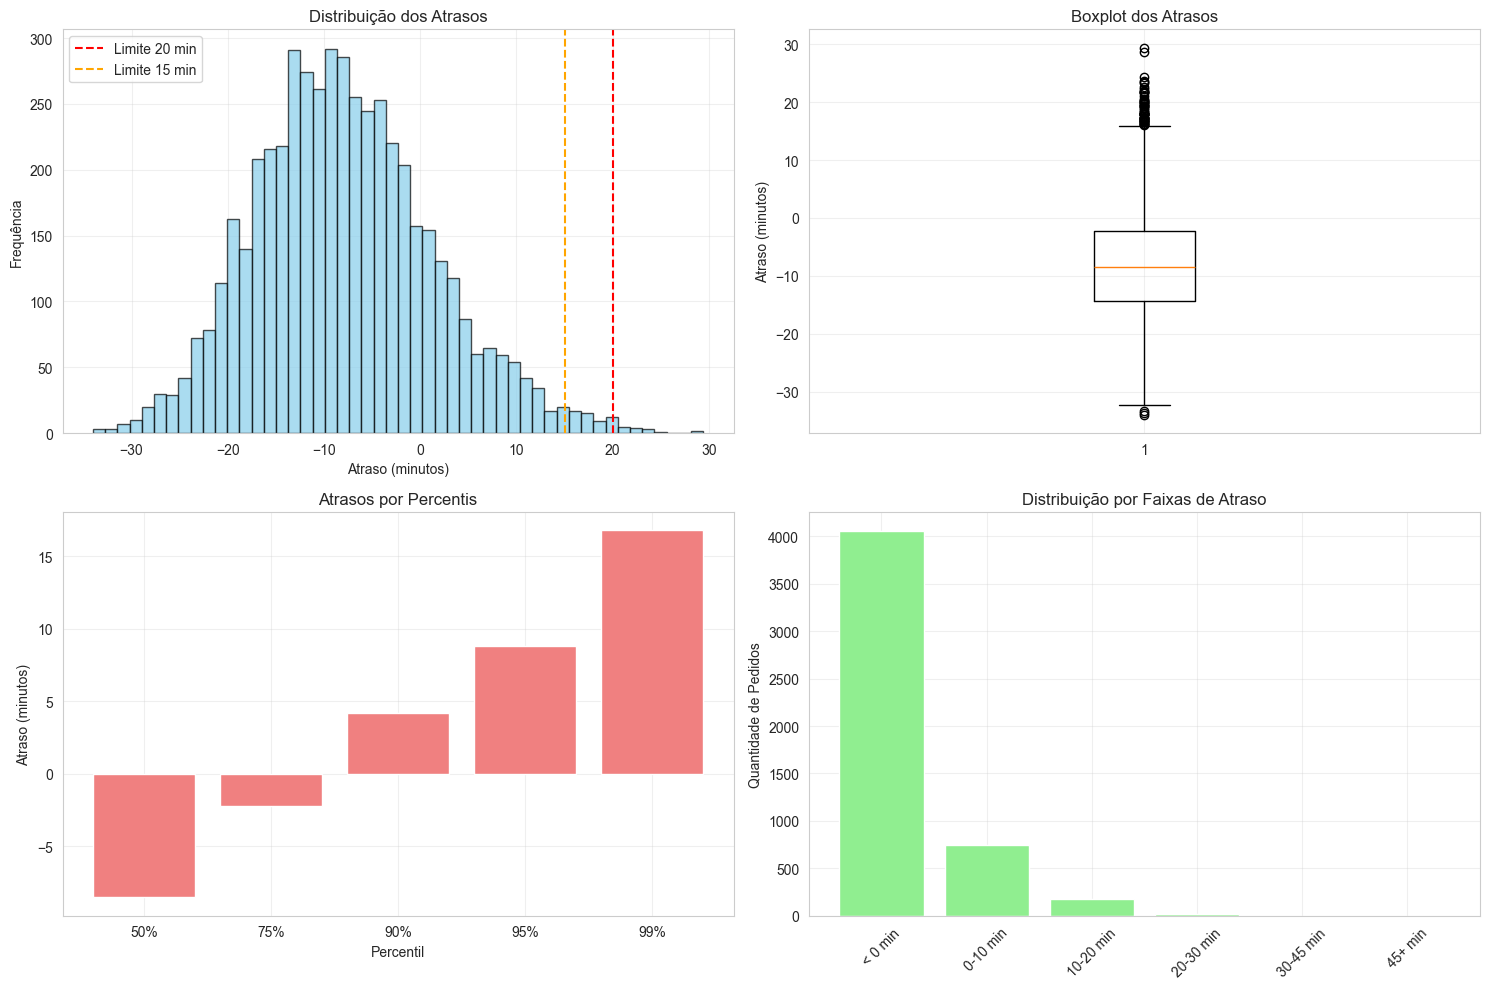

ESTATÍSTICAS DETALHADAS DOS ATRASOS:
Média: -7.91 minutos
Mediana: -8.50 minutos
Desvio padrão: 9.26 minutos

PEDIDOS COM ATRASO ≥ 20 MINUTOS:
Quantidade: 20 pedidos (0.4% do total)

PEDIDOS COM ATRASO ≥ 15 MINUTOS:
Quantidade: 75 pedidos (1.5% do total)


In [60]:
# Análise da distribuição de atrasos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# histograma de atrasos
axes[0,0].hist(df['atraso_minutos'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(x=20, color='red', linestyle='--', label='Limite 20 min')
axes[0,0].axvline(x=15, color='orange', linestyle='--', label='Limite 15 min')
axes[0,0].set_title('Distribuição dos Atrasos')
axes[0,0].set_xlabel('Atraso (minutos)')
axes[0,0].set_ylabel('Frequência')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# boxplot de atrasos
axes[0,1].boxplot(df['atraso_minutos'], vert=True)
axes[0,1].set_title('Boxplot dos Atrasos')
axes[0,1].set_ylabel('Atraso (minutos)')
axes[0,1].grid(True, alpha=0.3)

# distribuição por percentis
percentis = [50, 75, 90, 95, 99]
valores_percentis = [np.percentile(df['atraso_minutos'], p) for p in percentis]
axes[1,0].bar(range(len(percentis)), valores_percentis, color='lightcoral')
axes[1,0].set_title('Atrasos por Percentis')
axes[1,0].set_xlabel('Percentil')
axes[1,0].set_ylabel('Atraso (minutos)')
axes[1,0].set_xticks(range(len(percentis)))
axes[1,0].set_xticklabels([f'{p}%' for p in percentis])
axes[1,0].grid(True, alpha=0.3)

# Contagem de atrasos por faixas
faixas_atraso = ['< 0 min', '0-10 min', '10-20 min', '20-30 min', '30-45 min', '45+ min']
contagem_faixas = [
    len(df[df['atraso_minutos'] < 0]),
    len(df[(df['atraso_minutos'] >= 0) & (df['atraso_minutos'] < 10)]),
    len(df[(df['atraso_minutos'] >= 10) & (df['atraso_minutos'] < 20)]),
    len(df[(df['atraso_minutos'] >= 20) & (df['atraso_minutos'] < 30)]),
    len(df[(df['atraso_minutos'] >= 30) & (df['atraso_minutos'] < 45)]),
    len(df[df['atraso_minutos'] >= 45])
]

axes[1,1].bar(faixas_atraso, contagem_faixas, color='lightgreen')
axes[1,1].set_title('Distribuição por Faixas de Atraso')
axes[1,1].set_ylabel('Quantidade de Pedidos')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas detalhadas
print("ESTATÍSTICAS DETALHADAS DOS ATRASOS:")
print(f"Média: {df['atraso_minutos'].mean():.2f} minutos")
print(f"Mediana: {df['atraso_minutos'].median():.2f} minutos")
print(f"Desvio padrão: {df['atraso_minutos'].std():.2f} minutos")
print(f"\nPEDIDOS COM ATRASO ≥ 20 MINUTOS:")
atraso_20_plus = df[df['atraso_minutos'] >= 20]
print(f"Quantidade: {len(atraso_20_plus)} pedidos ({len(atraso_20_plus)/len(df)*100:.1f}% do total)")
print(f"\nPEDIDOS COM ATRASO ≥ 15 MINUTOS:")
atraso_15_plus = df[df['atraso_minutos'] >= 15]
print(f"Quantidade: {len(atraso_15_plus)} pedidos ({len(atraso_15_plus)/len(df)*100:.1f}% do total)")


## 4. Definição do Critério de Atraso e Análise Inicial


In [61]:
# Definir critério de atraso baseado na análise
if len(atraso_20_plus) >= 50:  # se houver pelo menos 50 casos com 20 min ou mais 
    limite_atraso = 20
    print(f"Usando limite de {limite_atraso} minutos (suficientes casos para análise)")
else:
    limite_atraso = 15
    print(f"Usando limite de {limite_atraso} minutos (poucos casos com 20+ min)")

# Filtrar pedidos com atraso grande
df_atraso_grande = df[df['atraso_minutos'] >= limite_atraso].copy()

print(f"\nPEDIDOS COM ATRASO GRANDE (≥ {limite_atraso} min):")
print(f"Quantidade: {len(df_atraso_grande)} pedidos")
print(f"Percentual do total: {len(df_atraso_grande)/len(df)*100:.1f}%")
print(f"\nEstatísticas dos atrasos grandes:")
print(df_atraso_grande['atraso_minutos'].describe())


Usando limite de 15 minutos (poucos casos com 20+ min)

PEDIDOS COM ATRASO GRANDE (≥ 15 min):
Quantidade: 75 pedidos
Percentual do total: 1.5%

Estatísticas dos atrasos grandes:
count    75.000000
mean     18.524933
std       2.979884
min      15.100000
25%      16.300000
50%      17.900000
75%      20.050000
max      29.400000
Name: atraso_minutos, dtype: float64


## 5. Análise Detalhada de Padrões em Atrasos Grandes (≥ 15 min)


In [62]:
# Análise específica para atrasos ≥ 15 minutos
df_atraso_15_plus = df[df['atraso_minutos'] >= 15].copy()

print("ANÁLISE DETALHADA DE PADRÕES EM ATRASOS ≥ 15 MINUTOS")
print("=" * 70)

# 1. Distribuição por plataforma
print("\n1️DISTRIBUIÇÃO POR PLATAFORMA:")
dist_plataforma = df_atraso_15_plus['platform'].value_counts()
dist_plataforma_pct = df_atraso_15_plus['platform'].value_counts(normalize=True) * 100

for platform in dist_plataforma.index:
    total_platform = len(df[df['platform'] == platform])
    atraso_platform = len(df_atraso_15_plus[df_atraso_15_plus['platform'] == platform])
    taxa_atraso = (atraso_platform / total_platform) * 100
    print(f"   • {platform}: {atraso_platform} pedidos ({dist_plataforma_pct[platform]:.1f}% dos atrasos, taxa: {taxa_atraso:.1f}%)")

# 2. Distribuição por bairro (top 10)
print("\n2️TOP 10 BAIRROS COM MAIS ATRASOS ≥ 15 MIN:")
top_bairros = df_atraso_15_plus['macro_bairro'].value_counts().head(10)
for bairro in top_bairros.index:
    total_bairro = len(df[df['macro_bairro'] == bairro])
    atraso_bairro = len(df_atraso_15_plus[df_atraso_15_plus['macro_bairro'] == bairro])
    taxa_atraso = (atraso_bairro / total_bairro) * 100
    print(f"   • {bairro}: {atraso_bairro} pedidos (taxa: {taxa_atraso:.1f}%)")

# 3. Distribuição por horário
print("\n3️DISTRIBUIÇÃO POR HORÁRIO:")
dist_horario = df_atraso_15_plus['faixa_horario'].value_counts()
for horario in dist_horario.index:
    total_horario = len(df[df['faixa_horario'] == horario])
    atraso_horario = len(df_atraso_15_plus[df_atraso_15_plus['faixa_horario'] == horario])
    taxa_atraso = (atraso_horario / total_horario) * 100
    print(f"   • {horario}: {atraso_horario} pedidos (taxa: {taxa_atraso:.1f}%)")

# 4. Distribuição por dia da semana
print("\n4️DISTRIBUIÇÃO POR DIA DA SEMANA:")
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dist_dia = df_atraso_15_plus['dia_semana'].value_counts().reindex(ordem_dias, fill_value=0)
for dia in dist_dia.index:
    if dist_dia[dia] > 0:
        total_dia = len(df[df['dia_semana'] == dia])
        atraso_dia = len(df_atraso_15_plus[df_atraso_15_plus['dia_semana'] == dia])
        taxa_atraso = (atraso_dia / total_dia) * 100
        print(f"   • {dia}: {atraso_dia} pedidos (taxa: {taxa_atraso:.1f}%)")

# 5. Distribuição por classe do pedido
print("\n5️DISTRIBUIÇÃO POR CLASSE DO PEDIDO:")
dist_classe = df_atraso_15_plus['classe_pedido'].value_counts()
for classe in dist_classe.index:
    total_classe = len(df[df['classe_pedido'] == classe])
    atraso_classe = len(df_atraso_15_plus[df_atraso_15_plus['classe_pedido'] == classe])
    taxa_atraso = (atraso_classe / total_classe) * 100
    print(f"   • {classe}: {atraso_classe} pedidos (taxa: {taxa_atraso:.1f}%)")

# 6. Distribuição por modo de entrega
print("\n6️DISTRIBUIÇÃO POR MODO DE ENTREGA:")
dist_modo = df_atraso_15_plus['order_mode'].value_counts()
for modo in dist_modo.index:
    total_modo = len(df[df['order_mode'] == modo])
    atraso_modo = len(df_atraso_15_plus[df_atraso_15_plus['order_mode'] == modo])
    taxa_atraso = (atraso_modo / total_modo) * 100
    print(f"   • {modo}: {atraso_modo} pedidos (taxa: {taxa_atraso:.1f}%)")


ANÁLISE DETALHADA DE PADRÕES EM ATRASOS ≥ 15 MINUTOS

1️DISTRIBUIÇÃO POR PLATAFORMA:
   • ifood: 47 pedidos (62.7% dos atrasos, taxa: 1.8%)
   • rappi: 11 pedidos (14.7% dos atrasos, taxa: 1.5%)
   • site_proprio: 9 pedidos (12.0% dos atrasos, taxa: 0.9%)
   • whatsapp: 8 pedidos (10.7% dos atrasos, taxa: 1.5%)

2️TOP 10 BAIRROS COM MAIS ATRASOS ≥ 15 MIN:
   • Morumbi: 14 pedidos (taxa: 4.0%)
   • Vila Mariana: 11 pedidos (taxa: 2.1%)
   • Jardins: 9 pedidos (taxa: 2.2%)
   • Outros: 8 pedidos (taxa: 2.2%)
   • Santo Amaro: 8 pedidos (taxa: 2.1%)
   • Moema: 6 pedidos (taxa: 0.9%)
   • Pinheiros: 6 pedidos (taxa: 1.5%)
   • Vila Olímpia: 6 pedidos (taxa: 1.2%)
   • Itaim: 4 pedidos (taxa: 0.8%)
   • Brooklin: 3 pedidos (taxa: 0.3%)

3️DISTRIBUIÇÃO POR HORÁRIO:
   • Noite (18h-24h): 25 pedidos (taxa: 1.6%)
   • Tarde (12h-18h): 24 pedidos (taxa: 1.3%)
   • Manhã (6h-12h): 22 pedidos (taxa: 1.6%)
   • Madrugada (0h-6h): 4 pedidos (taxa: 3.0%)

4️DISTRIBUIÇÃO POR DIA DA SEMANA:
   • Monda

## 6. Análise de Combinações Problemáticas


In [63]:
# Análise de combinações problemáticas que causam atrasos ≥ 15 min
print("ANÁLISE DE COMBINAÇÕES PROBLEMÁTICAS")
print("=" * 50)

# 1. Plataforma + Bairro
print("\n1️ COMBINAÇÕES PLATAFORMA + BAIRRO MAIS PROBLEMÁTICAS:")
combinacoes_plataforma_bairro = df_atraso_15_plus.groupby(['platform', 'macro_bairro']).size().sort_values(ascending=False).head(10)
for (platform, bairro), count in combinacoes_plataforma_bairro.items():
    total_combinacao = len(df[(df['platform'] == platform) & (df['macro_bairro'] == bairro)])
    taxa_atraso = (count / total_combinacao) * 100
    print(f"   • {platform} + {bairro}: {count} atrasos (taxa: {taxa_atraso:.1f}%)")

# 2. Plataforma + Horário
print("\n2️ COMBINAÇÕES PLATAFORMA + HORÁRIO MAIS PROBLEMÁTICAS:")
combinacoes_plataforma_horario = df_atraso_15_plus.groupby(['platform', 'faixa_horario']).size().sort_values(ascending=False).head(10)
for (platform, horario), count in combinacoes_plataforma_horario.items():
    total_combinacao = len(df[(df['platform'] == platform) & (df['faixa_horario'] == horario)])
    taxa_atraso = (count / total_combinacao) * 100
    print(f"   • {platform} + {horario}: {count} atrasos (taxa: {taxa_atraso:.1f}%)")

# 3. Bairro + Horário
print("\n3️ COMBINAÇÕES BAIRRO + HORÁRIO MAIS PROBLEMÁTICAS:")
combinacoes_bairro_horario = df_atraso_15_plus.groupby(['macro_bairro', 'faixa_horario']).size().sort_values(ascending=False).head(10)
for (bairro, horario), count in combinacoes_bairro_horario.items():
    total_combinacao = len(df[(df['macro_bairro'] == bairro) & (df['faixa_horario'] == horario)])
    taxa_atraso = (count / total_combinacao) * 100
    print(f"   • {bairro} + {horario}: {count} atrasos (taxa: {taxa_atraso:.1f}%)")

# 4. Classe + Plataforma
print("\n4️ COMBINAÇÕES CLASSE + PLATAFORMA MAIS PROBLEMÁTICAS:")
combinacoes_classe_plataforma = df_atraso_15_plus.groupby(['classe_pedido', 'platform']).size().sort_values(ascending=False).head(10)
for (classe, platform), count in combinacoes_classe_plataforma.items():
    total_combinacao = len(df[(df['classe_pedido'] == classe) & (df['platform'] == platform)])
    taxa_atraso = (count / total_combinacao) * 100
    print(f"   • {classe} + {platform}: {count} atrasos (taxa: {taxa_atraso:.1f}%)")

# 5. Análise de distância nos atrasos
print("\n5️ ANÁLISE DE DISTÂNCIA NOS ATRASOS ≥ 15 MIN:")
print(f"   • Distância média: {df_atraso_15_plus['distance_km'].mean():.2f} km")
print(f"   • Distância mediana: {df_atraso_15_plus['distance_km'].median():.2f} km")
print(f"   • Distância máxima: {df_atraso_15_plus['distance_km'].max():.2f} km")
print(f"   • Distância mínima: {df_atraso_15_plus['distance_km'].min():.2f} km")

# Comparar com distância geral
print(f"\n   COMPARAÇÃO COM DISTÂNCIA GERAL:")
print(f"   • Distância média geral: {df['distance_km'].mean():.2f} km")
print(f"   • Distância mediana geral: {df['distance_km'].median():.2f} km")

# 6. Análise de número de itens nos atrasos
print("\n6️ ANÁLISE DE NÚMERO DE ITENS NOS ATRASOS ≥ 15 MIN:")
print(f"   • Itens médios: {df_atraso_15_plus['num_itens'].mean():.1f}")
print(f"   • Itens medianos: {df_atraso_15_plus['num_itens'].median():.1f}")
print(f"   • Itens máximos: {df_atraso_15_plus['num_itens'].max()}")
print(f"   • Itens mínimos: {df_atraso_15_plus['num_itens'].min()}")

print(f"\n   COMPARAÇÃO COM ITENS GERAIS:")
print(f"   • Itens médios gerais: {df['num_itens'].mean():.1f}")
print(f"   • Itens medianos gerais: {df['num_itens'].median():.1f}")

# 7. Análise de tempo de preparo nos atrasos
print("\n7️ ANÁLISE DE TEMPO DE PREPARO NOS ATRASOS ≥ 15 MIN:")
print(f"   • Preparo médio: {df_atraso_15_plus['tempo_preparo_minutos'].mean():.1f} min")
print(f"   • Preparo mediano: {df_atraso_15_plus['tempo_preparo_minutos'].median():.1f} min")
print(f"   • Preparo máximo: {df_atraso_15_plus['tempo_preparo_minutos'].max():.1f} min")
print(f"   • Preparo mínimo: {df_atraso_15_plus['tempo_preparo_minutos'].min():.1f} min")

print(f"\n   COMPARAÇÃO COM PREPARO GERAL:")
print(f"   • Preparo médio geral: {df['tempo_preparo_minutos'].mean():.1f} min")
print(f"   • Preparo mediano geral: {df['tempo_preparo_minutos'].median():.1f} min")


ANÁLISE DE COMBINAÇÕES PROBLEMÁTICAS

1️ COMBINAÇÕES PLATAFORMA + BAIRRO MAIS PROBLEMÁTICAS:
   • ifood + Morumbi: 9 atrasos (taxa: 4.9%)
   • ifood + Vila Mariana: 7 atrasos (taxa: 2.3%)
   • ifood + Outros: 5 atrasos (taxa: 2.7%)
   • ifood + Jardins: 5 atrasos (taxa: 2.2%)
   • ifood + Moema: 4 atrasos (taxa: 1.1%)
   • ifood + Pinheiros: 4 atrasos (taxa: 2.0%)
   • ifood + Santo Amaro: 4 atrasos (taxa: 2.1%)
   • ifood + Vila Olímpia: 4 atrasos (taxa: 1.7%)
   • site_proprio + Jardins: 4 atrasos (taxa: 4.5%)
   • ifood + Itaim: 3 atrasos (taxa: 1.1%)

2️ COMBINAÇÕES PLATAFORMA + HORÁRIO MAIS PROBLEMÁTICAS:
   • ifood + Noite (18h-24h): 16 atrasos (taxa: 1.9%)
   • ifood + Tarde (12h-18h): 15 atrasos (taxa: 1.5%)
   • ifood + Manhã (6h-12h): 13 atrasos (taxa: 1.8%)
   • rappi + Manhã (6h-12h): 5 atrasos (taxa: 2.3%)
   • site_proprio + Noite (18h-24h): 4 atrasos (taxa: 1.2%)
   • whatsapp + Manhã (6h-12h): 4 atrasos (taxa: 2.9%)
   • site_proprio + Tarde (12h-18h): 4 atrasos (taxa: 

## 7. Análise de Correlações Específicas para Atrasos Grandes


In [64]:
print("ANÁLISE DE CORRELAÇÕES ESPECÍFICAS PARA ATRASOS ≥ 15 MIN")
print("=" * 70)

print("\n1️ CORRELAÇÕES NUMÉRICAS NOS ATRASOS GRANDES:")
correlacoes_atraso = df_atraso_15_plus[['atraso_minutos', 'distance_km', 'tempo_preparo_minutos', 
                                       'num_itens', 'eta_minutes_quote', 'actual_delivery_minutes']].corr()

print("Correlação entre variáveis nos atrasos ≥ 15 min:")
for var in ['distance_km', 'tempo_preparo_minutos', 'num_itens', 'eta_minutes_quote']:
    corr = correlacoes_atraso.loc['atraso_minutos', var]
    print(f"   • {var} vs atraso: {corr:.3f}")


print("\n2️ COMPARAÇÃO COM CORRELAÇÕES GERAIS:")
correlacoes_geral = df[['atraso_minutos', 'distance_km', 'tempo_preparo_minutos', 
                       'num_itens', 'eta_minutes_quote', 'actual_delivery_minutes']].corr()

print("Diferença nas correlações (Atrasos Grandes vs Geral):")
for var in ['distance_km', 'tempo_preparo_minutos', 'num_itens', 'eta_minutes_quote']:
    corr_atraso = correlacoes_atraso.loc['atraso_minutos', var]
    corr_geral = correlacoes_geral.loc['atraso_minutos', var]
    diff = corr_atraso - corr_geral
    print(f"   • {var}: {corr_atraso:.3f} vs {corr_geral:.3f} (diff: {diff:+.3f})")


print("\n3️ ANÁLISE POR FAIXAS DE DISTÂNCIA NOS ATRASOS ≥ 15 MIN:")
df_atraso_15_plus['faixa_distancia'] = pd.cut(df_atraso_15_plus['distance_km'], 
                                             bins=[0, 2, 5, 10, 20, float('inf')], 
                                             labels=['0-2km', '2-5km', '5-10km', '10-20km', '20+km'])

dist_distancia_atraso = df_atraso_15_plus['faixa_distancia'].value_counts()

faixas_limites = {
    '0-2km': (0, 2),
    '2-5km': (2, 5),
    '5-10km': (5, 10),
    '10-20km': (10, 20),
    '20+km': (20, float('inf'))
}

for faixa in dist_distancia_atraso.index:
    if faixa in faixas_limites:
        min_dist, max_dist = faixas_limites[faixa]
        if max_dist == float('inf'):
            total_faixa = len(df[df['distance_km'] >= min_dist])
        else:
            total_faixa = len(df[(df['distance_km'] >= min_dist) & (df['distance_km'] < max_dist)])
        
        atraso_faixa = dist_distancia_atraso[faixa]
        taxa_atraso = (atraso_faixa / total_faixa) * 100
        print(f"   • {faixa}: {atraso_faixa} atrasos (taxa: {taxa_atraso:.1f}%)")

print("\n4️ ANÁLISE POR FAIXAS DE ITENS NOS ATRASOS ≥ 15 MIN:")
df_atraso_15_plus['faixa_itens'] = pd.cut(df_atraso_15_plus['num_itens'], 
                                         bins=[0, 1, 3, 5, 10, float('inf')], 
                                         labels=['1 item', '2-3 itens', '4-5 itens', '6-10 itens', '10+ itens'])

dist_itens_atraso = df_atraso_15_plus['faixa_itens'].value_counts()

faixas_itens_limites = {
    '1 item': (1, 1),
    '2-3 itens': (2, 3),
    '4-5 itens': (4, 5),
    '6-10 itens': (6, 10),
    '10+ itens': (11, float('inf'))
}

for faixa in dist_itens_atraso.index:
    if faixa in faixas_itens_limites:
        min_itens, max_itens = faixas_itens_limites[faixa]
        if max_itens == float('inf'):
            total_faixa = len(df[df['num_itens'] >= min_itens])
        else:
            total_faixa = len(df[(df['num_itens'] >= min_itens) & (df['num_itens'] <= max_itens)])
        
        atraso_faixa = dist_itens_atraso[faixa]
        taxa_atraso = (atraso_faixa / total_faixa) * 100
        print(f"   • {faixa}: {atraso_faixa} atrasos (taxa: {taxa_atraso:.1f}%)")

print("\n5️ ANÁLISE POR FAIXAS DE PREPARO NOS ATRASOS ≥ 15 MIN:")
df_atraso_15_plus['faixa_preparo'] = pd.cut(df_atraso_15_plus['tempo_preparo_minutos'], 
                                           bins=[0, 15, 25, 35, 50, float('inf')], 
                                           labels=['0-15min', '15-25min', '25-35min', '35-50min', '50+min'])

dist_preparo_atraso = df_atraso_15_plus['faixa_preparo'].value_counts()

faixas_preparo_limites = {
    '0-15min': (0, 15),
    '15-25min': (15, 25),
    '25-35min': (25, 35),
    '35-50min': (35, 50),
    '50+min': (50, float('inf'))
}

for faixa in dist_preparo_atraso.index:
    if faixa in faixas_preparo_limites:
        min_preparo, max_preparo = faixas_preparo_limites[faixa]
        if max_preparo == float('inf'):
            total_faixa = len(df[df['tempo_preparo_minutos'] >= min_preparo])
        else:
            total_faixa = len(df[(df['tempo_preparo_minutos'] >= min_preparo) & (df['tempo_preparo_minutos'] < max_preparo)])
        
        atraso_faixa = dist_preparo_atraso[faixa]
        taxa_atraso = (atraso_faixa / total_faixa) * 100
        print(f"   • {faixa}: {atraso_faixa} atrasos (taxa: {taxa_atraso:.1f}%)")


ANÁLISE DE CORRELAÇÕES ESPECÍFICAS PARA ATRASOS ≥ 15 MIN

1️ CORRELAÇÕES NUMÉRICAS NOS ATRASOS GRANDES:
Correlação entre variáveis nos atrasos ≥ 15 min:
   • distance_km vs atraso: 0.059
   • tempo_preparo_minutos vs atraso: 0.392
   • num_itens vs atraso: 0.099
   • eta_minutes_quote vs atraso: 0.135

2️ COMPARAÇÃO COM CORRELAÇÕES GERAIS:
Diferença nas correlações (Atrasos Grandes vs Geral):
   • distance_km: 0.059 vs 0.072 (diff: -0.013)
   • tempo_preparo_minutos: 0.392 vs 0.688 (diff: -0.296)
   • num_itens: 0.099 vs 0.398 (diff: -0.298)
   • eta_minutes_quote: 0.135 vs 0.009 (diff: +0.126)

3️ ANÁLISE POR FAIXAS DE DISTÂNCIA NOS ATRASOS ≥ 15 MIN:
   • 5-10km: 41 atrasos (taxa: 2.6%)
   • 2-5km: 24 atrasos (taxa: 1.3%)
   • 0-2km: 10 atrasos (taxa: 0.6%)
   • 10-20km: 0 atrasos (taxa: nan%)
   • 20+km: 0 atrasos (taxa: nan%)

4️ ANÁLISE POR FAIXAS DE ITENS NOS ATRASOS ≥ 15 MIN:
   • 6-10 itens: 46 atrasos (taxa: 8.6%)
   • 4-5 itens: 23 atrasos (taxa: 1.7%)
   • 2-3 itens: 5 atraso

## 8. Visualizações dos Padrões de Atrasos


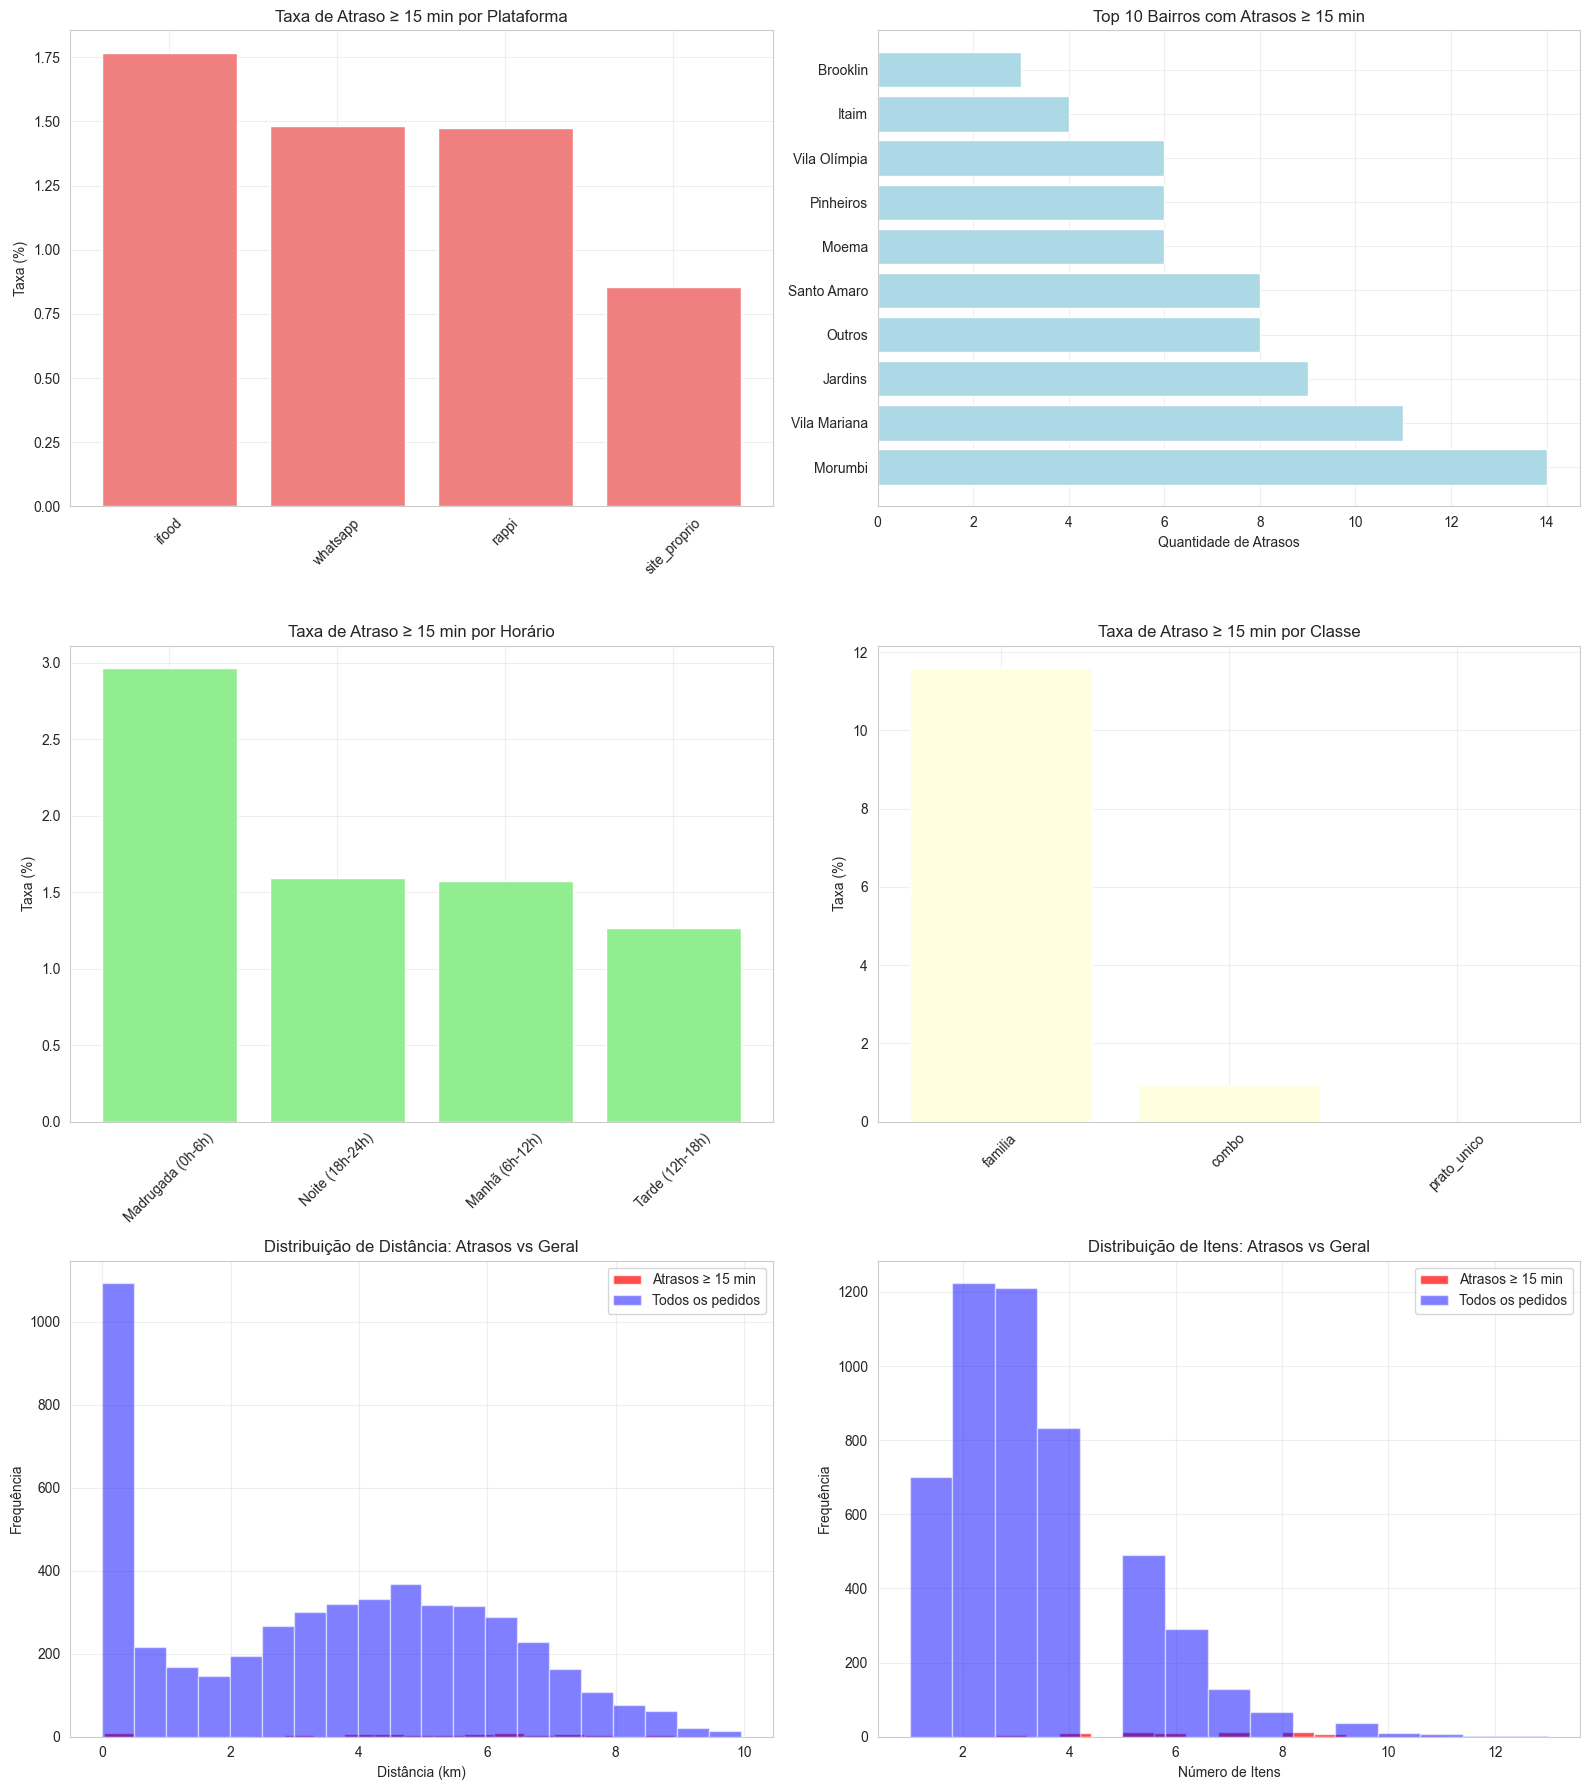

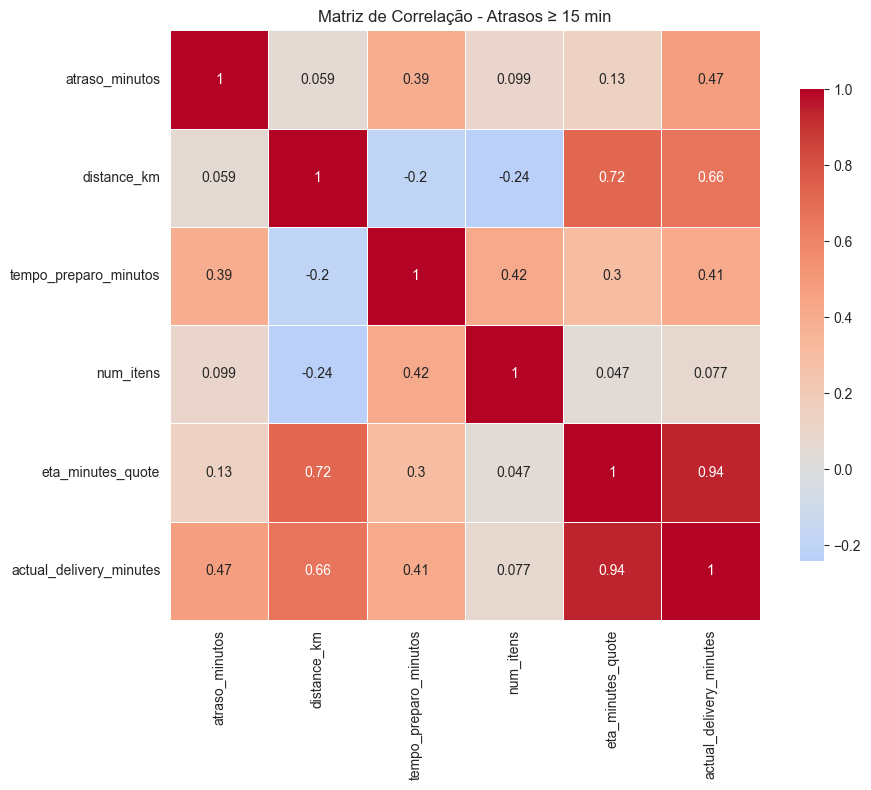

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# t axa de atraso por plataforma
taxa_atraso_plataforma = df.groupby('platform').apply(
    lambda x: len(x[x['atraso_minutos'] >= 15]) / len(x) * 100
).sort_values(ascending=False)

axes[0,0].bar(taxa_atraso_plataforma.index, taxa_atraso_plataforma.values, color='lightcoral')
axes[0,0].set_title('Taxa de Atraso ≥ 15 min por Plataforma')
axes[0,0].set_ylabel('Taxa (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

top_bairros_atraso = df_atraso_15_plus['macro_bairro'].value_counts().head(10)
axes[0,1].barh(range(len(top_bairros_atraso)), top_bairros_atraso.values, color='lightblue')
axes[0,1].set_yticks(range(len(top_bairros_atraso)))
axes[0,1].set_yticklabels(top_bairros_atraso.index)
axes[0,1].set_title('Top 10 Bairros com Atrasos ≥ 15 min')
axes[0,1].set_xlabel('Quantidade de Atrasos')
axes[0,1].grid(True, alpha=0.3)

taxa_atraso_horario = df.groupby('faixa_horario').apply(
    lambda x: len(x[x['atraso_minutos'] >= 15]) / len(x) * 100
).sort_values(ascending=False)

axes[1,0].bar(taxa_atraso_horario.index, taxa_atraso_horario.values, color='lightgreen')
axes[1,0].set_title('Taxa de Atraso ≥ 15 min por Horário')
axes[1,0].set_ylabel('Taxa (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)


taxa_atraso_classe = df.groupby('classe_pedido').apply(
    lambda x: len(x[x['atraso_minutos'] >= 15]) / len(x) * 100
).sort_values(ascending=False)

axes[1,1].bar(taxa_atraso_classe.index, taxa_atraso_classe.values, color='lightyellow')
axes[1,1].set_title('Taxa de Atraso ≥ 15 min por Classe')
axes[1,1].set_ylabel('Taxa (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# distribuição de distância nos atrasos vs geral
axes[2,0].hist(df_atraso_15_plus['distance_km'], bins=20, alpha=0.7, label='Atrasos ≥ 15 min', color='red')
axes[2,0].hist(df['distance_km'], bins=20, alpha=0.5, label='Todos os pedidos', color='blue')
axes[2,0].set_title('Distribuição de Distância: Atrasos vs Geral')
axes[2,0].set_xlabel('Distância (km)')
axes[2,0].set_ylabel('Frequência')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

axes[2,1].hist(df_atraso_15_plus['num_itens'], bins=15, alpha=0.7, label='Atrasos ≥ 15 min', color='red')
axes[2,1].hist(df['num_itens'], bins=15, alpha=0.5, label='Todos os pedidos', color='blue')
axes[2,1].set_title('Distribuição de Itens: Atrasos vs Geral')
axes[2,1].set_xlabel('Número de Itens')
axes[2,1].set_ylabel('Frequência')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# heatmap de correlações para atrasos grandes
plt.figure(figsize=(10, 8))
correlacoes_heatmap = df_atraso_15_plus[['atraso_minutos', 'distance_km', 'tempo_preparo_minutos', 
                                        'num_itens', 'eta_minutes_quote', 'actual_delivery_minutes']].corr()
sns.heatmap(correlacoes_heatmap, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Atrasos ≥ 15 min')
plt.tight_layout()
plt.show()


## 9. Análise de Casos Extremos e Padrões Específicos


In [66]:
print("ANÁLISE DE CASOS EXTREMOS DE ATRASO ≥ 15 MINUTOS")
print("=" * 70)

# Top 20 casos com maior atraso
casos_extremos = df_atraso_15_plus.nlargest(20, 'atraso_minutos')

print("\n1️ TOP 20 CASOS COM MAIOR ATRASO:")
print("-" * 50)
for idx, row in casos_extremos.iterrows():
    print(f"Pedido #{idx}: {row['atraso_minutos']:.1f} min de atraso")
    print(f"   • {row['platform']} | {row['macro_bairro']} | {row['faixa_horario']}")
    print(f"   • {row['classe_pedido']} | {row['num_itens']} itens | {row['distance_km']:.1f} km")
    print(f"   • ETA: {row['eta_minutes_quote']} min | Real: {row['actual_delivery_minutes']} min")
    print()


print("\n2️ PADRÕES NOS CASOS EXTREMOS:")
print("-" * 40)

print("Plataformas mais problemáticas nos casos extremos:")
print(casos_extremos['platform'].value_counts())

print("\nBairros mais problemáticos nos casos extremos:")
print(casos_extremos['macro_bairro'].value_counts().head(5))

print("\nHorários mais problemáticos nos casos extremos:")
print(casos_extremos['faixa_horario'].value_counts())

print("\nClasses mais problemáticas nos casos extremos:")
print(casos_extremos['classe_pedido'].value_counts())

# Análise de características específicas dos casos extremos
print("\n3️ CARACTERÍSTICAS DOS CASOS EXTREMOS:")
print("-" * 45)

print(f"Distância média nos casos extremos: {casos_extremos['distance_km'].mean():.2f} km")
print(f"Distância mediana nos casos extremos: {casos_extremos['distance_km'].median():.2f} km")
print(f"Distância máxima nos casos extremos: {casos_extremos['distance_km'].max():.2f} km")

print(f"\nItens médios nos casos extremos: {casos_extremos['num_itens'].mean():.1f}")
print(f"Itens medianos nos casos extremos: {casos_extremos['num_itens'].median():.1f}")
print(f"Itens máximos nos casos extremos: {casos_extremos['num_itens'].max()}")

print(f"\nTempo de preparo médio nos casos extremos: {casos_extremos['tempo_preparo_minutos'].mean():.1f} min")
print(f"Tempo de preparo mediano nos casos extremos: {casos_extremos['tempo_preparo_minutos'].median():.1f} min")
print(f"Tempo de preparo máximo nos casos extremos: {casos_extremos['tempo_preparo_minutos'].max():.1f} min")

# Análise de subgrupos problemáticos
print("\n4️ SUBGRUPOS MAIS PROBLEMÁTICOS:")
print("-" * 40)

# Subgrupos com maior taxa de atraso
subgrupos_problematicos = []

# Plataforma + Bairro
for (platform, bairro), group in df.groupby(['platform', 'macro_bairro']):
    if len(group) >= 10:  # Pelo menos 10 pedidos
        taxa_atraso = len(group[group['atraso_minutos'] >= 15]) / len(group) * 100
        if taxa_atraso >= 20:  # Taxa alta de atraso
            subgrupos_problematicos.append({
                'tipo': f'{platform} + {bairro}',
                'taxa_atraso': taxa_atraso,
                'total_pedidos': len(group),
                'atrasos': len(group[group['atraso_minutos'] >= 15])
            })

# Plataforma + Horário
for (platform, horario), group in df.groupby(['platform', 'faixa_horario']):
    if len(group) >= 10:
        taxa_atraso = len(group[group['atraso_minutos'] >= 15]) / len(group) * 100
        if taxa_atraso >= 20:
            subgrupos_problematicos.append({
                'tipo': f'{platform} + {horario}',
                'taxa_atraso': taxa_atraso,
                'total_pedidos': len(group),
                'atrasos': len(group[group['atraso_minutos'] >= 15])
            })

# Ordenar por taxa de atraso
subgrupos_problematicos.sort(key=lambda x: x['taxa_atraso'], reverse=True)

print("Top 10 subgrupos mais problemáticos (taxa ≥ 20%):")
for i, subgrupo in enumerate(subgrupos_problematicos[:10], 1):
    print(f"   {i}. {subgrupo['tipo']}: {subgrupo['taxa_atraso']:.1f}% "
          f"({subgrupo['atrasos']}/{subgrupo['total_pedidos']} pedidos)")

# Análise de padrões temporais específicos
print("\n5️ PADRÕES TEMPORAIS ESPECÍFICOS:")
print("-" * 40)

# Análise por hora específica
horas_problematicas = df_atraso_15_plus['hora_pedido'].value_counts().head(5)
print("Horas com mais atrasos ≥ 15 min:")
for hora, count in horas_problematicas.items():
    total_hora = len(df[df['hora_pedido'] == hora])
    taxa = (count / total_hora) * 100
    print(f"   • {hora}h: {count} atrasos (taxa: {taxa:.1f}%)")

# Análise de fim de semana vs dia útil
fim_semana_atraso = len(df_atraso_15_plus[df_atraso_15_plus['is_weekend'] == True])
dia_util_atraso = len(df_atraso_15_plus[df_atraso_15_plus['is_weekend'] == False])

total_fim_semana = len(df[df['is_weekend'] == True])
total_dia_util = len(df[df['is_weekend'] == False])

taxa_fim_semana = (fim_semana_atraso / total_fim_semana) * 100
taxa_dia_util = (dia_util_atraso / total_dia_util) * 100

print(f"\nFim de semana vs Dia útil:")
print(f"   • Fim de semana: {fim_semana_atraso} atrasos (taxa: {taxa_fim_semana:.1f}%)")
print(f"   • Dia útil: {dia_util_atraso} atrasos (taxa: {taxa_dia_util:.1f}%)")
print(f"   • Diferença: {taxa_fim_semana - taxa_dia_util:+.1f} pontos percentuais")


ANÁLISE DE CASOS EXTREMOS DE ATRASO ≥ 15 MINUTOS

1️ TOP 20 CASOS COM MAIOR ATRASO:
--------------------------------------------------
Pedido #4408: 29.4 min de atraso
   • site_proprio | Jardins | Tarde (12h-18h)
   • familia | 6 itens | 5.8 km
   • ETA: 46 min | Real: 75.4 min

Pedido #1365: 28.7 min de atraso
   • ifood | Jardins | Tarde (12h-18h)
   • familia | 5 itens | 6.3 km
   • ETA: 47 min | Real: 75.7 min

Pedido #2477: 24.4 min de atraso
   • ifood | Outros | Noite (18h-24h)
   • familia | 4 itens | 6.6 km
   • ETA: 45 min | Real: 69.4 min

Pedido #3670: 23.7 min de atraso
   • ifood | Vila Mariana | Manhã (6h-12h)
   • familia | 8 itens | 7.1 km
   • ETA: 53 min | Real: 76.7 min

Pedido #3553: 23.5 min de atraso
   • ifood | Pinheiros | Manhã (6h-12h)
   • familia | 7 itens | 4.1 km
   • ETA: 42 min | Real: 65.5 min

Pedido #4251: 23.4 min de atraso
   • ifood | Santo Amaro | Noite (18h-24h)
   • familia | 6 itens | 6.4 km
   • ETA: 47 min | Real: 70.4 min

Pedido #4449: 22

## Análise Detalhada: Tempo de Preparo vs Atrasos


In [67]:

print("ANÁLISE DETALHADA: TEMPO DE PREPARO vs ATRASOS")
print("=" * 60)


print("\n1️ CORRELAÇÃO TEMPO DE PREPARO vs ATRASO:")
print("-" * 50)


corr_geral = df['tempo_preparo_minutos'].corr(df['atraso_minutos'])
print(f"   • Correlação GERAL: {corr_geral:.3f}")

# Correlação nos atrasos grandes
corr_atraso_grande = df_atraso_15_plus['tempo_preparo_minutos'].corr(df_atraso_15_plus['atraso_minutos'])
print(f"   • Correlação ATRASOS ≥ 15 min: {corr_atraso_grande:.3f}")

# Correlação nos pedidos sem atraso grande
df_sem_atraso_grande = df[df['atraso_minutos'] < 15]
corr_sem_atraso = df_sem_atraso_grande['tempo_preparo_minutos'].corr(df_sem_atraso_grande['atraso_minutos'])
print(f"   • Correlação SEM atraso grande: {corr_sem_atraso:.3f}")


print("\n2️ ANÁLISE POR FAIXAS DE TEMPO DE PREPARO:")
print("-" * 50)

# cirando faixas de tempo de preparo
df['faixa_preparo_geral'] = pd.cut(df['tempo_preparo_minutos'], 
                                  bins=[0, 15, 25, 35, 50, float('inf')], 
                                  labels=['0-15min', '15-25min', '25-35min', '35-50min', '50+min'])


print("Taxa de atraso ≥ 15 min por faixa de preparo:")
for faixa in df['faixa_preparo_geral'].cat.categories:
    if pd.notna(faixa):
        df_faixa = df[df['faixa_preparo_geral'] == faixa]
        total_faixa = len(df_faixa)
        atrasos_faixa = len(df_faixa[df_faixa['atraso_minutos'] >= 15])
        taxa_atraso = (atrasos_faixa / total_faixa) * 100
        
        # Estatísticas da faixa
        prep_medio = df_faixa['tempo_preparo_minutos'].mean()
        atraso_medio = df_faixa['atraso_minutos'].mean()
        
        print(f"   • {faixa}:")
        print(f"     Taxa de atraso: {taxa_atraso:.1f}% ({atrasos_faixa}/{total_faixa})")
        print(f"     Preparo médio: {prep_medio:.1f} min")
        print(f"     Atraso médio: {atraso_medio:.1f} min")
        print()

print("\n3️ PRECISÃO DO ETA POR TEMPO DE PREPARO:")
print("-" * 50)

print("Precisão do ETA (erro ≤ 10 min) por faixa de preparo:")
for faixa in df['faixa_preparo_geral'].cat.categories:
    if pd.notna(faixa):
        df_faixa = df[df['faixa_preparo_geral'] == faixa]
        total_faixa = len(df_faixa)
        precisos = len(df_faixa[abs(df_faixa['atraso_minutos']) <= 10])
        precisao = (precisos / total_faixa) * 100
        
        print(f"   • {faixa}: {precisao:.1f}% de precisão ({precisos}/{total_faixa})")


print("\n4️ VARIABILIDADE DO ATRASO POR TEMPO DE PREPARO:")
print("-" * 55)

print("Desvio padrão do atraso por faixa de preparo:")
for faixa in df['faixa_preparo_geral'].cat.categories:
    if pd.notna(faixa):
        df_faixa = df[df['faixa_preparo_geral'] == faixa]
        std_atraso = df_faixa['atraso_minutos'].std()
        print(f"   • {faixa}: {std_atraso:.1f} min (desvio padrão)")

print("\n5️ CASOS EXTREMOS POR TEMPO DE PREPARO:")
print("-" * 50)

print("Top 10 maiores atrasos por faixa de preparo:")
for faixa in df['faixa_preparo_geral'].cat.categories:
    if pd.notna(faixa):
        df_faixa = df[df['faixa_preparo_geral'] == faixa]
        maiores_atrasos = df_faixa.nlargest(3, 'atraso_minutos')
        
        if len(maiores_atrasos) > 0:
            print(f"\n   {faixa}:")
            for idx, row in maiores_atrasos.iterrows():
                print(f"     • Atraso: {row['atraso_minutos']:.1f} min | Preparo: {row['tempo_preparo_minutos']:.1f} min | ETA: {row['eta_minutes_quote']:.1f} min")

print("\n6️ ANÁLISE DE SUBESTIMAÇÃO DO ETA:")
print("-" * 40)

print("Diferença média entre ETA e tempo real por faixa de preparo:")
for faixa in df['faixa_preparo_geral'].cat.categories:
    if pd.notna(faixa):
        df_faixa = df[df['faixa_preparo_geral'] == faixa]
        
        # diferença ETA vs tempo real
        df_faixa['diferenca_eta_real'] = df_faixa['eta_minutes_quote'] - df_faixa['actual_delivery_minutes']
        diff_media = df_faixa['diferenca_eta_real'].mean()
        
        # percentual de subestimação
        subestimados = len(df_faixa[df_faixa['diferenca_eta_real'] < 0])
        total_faixa = len(df_faixa)
        pct_subestimacao = (subestimados / total_faixa) * 100
        
        print(f"   • {faixa}:")
        print(f"     - Diferença média ETA-Real: {diff_media:.1f} min")
        print(f"     - % de subestimação: {pct_subestimacao:.1f}%")
        print(f"     - ETA médio: {df_faixa['eta_minutes_quote'].mean():.1f} min")
        print(f"     - Tempo real médio: {df_faixa['actual_delivery_minutes'].mean():.1f} min")
        print()


ANÁLISE DETALHADA: TEMPO DE PREPARO vs ATRASOS

1️ CORRELAÇÃO TEMPO DE PREPARO vs ATRASO:
--------------------------------------------------
   • Correlação GERAL: 0.688
   • Correlação ATRASOS ≥ 15 min: 0.392
   • Correlação SEM atraso grande: 0.650

2️ ANÁLISE POR FAIXAS DE TEMPO DE PREPARO:
--------------------------------------------------
Taxa de atraso ≥ 15 min por faixa de preparo:
   • 0-15min:
     Taxa de atraso: 0.0% (0/2589)
     Preparo médio: 10.5 min
     Atraso médio: -12.7 min

   • 15-25min:
     Taxa de atraso: 0.2% (3/1780)
     Preparo médio: 19.7 min
     Atraso médio: -5.3 min

   • 25-35min:
     Taxa de atraso: 5.4% (27/500)
     Preparo médio: 29.4 min
     Atraso médio: 2.4 min

   • 35-50min:
     Taxa de atraso: 33.1% (42/127)
     Preparo médio: 40.0 min
     Atraso médio: 11.5 min

   • 50+min:
     Taxa de atraso: 75.0% (3/4)
     Preparo médio: 53.5 min
     Atraso médio: 20.4 min


3️ PRECISÃO DO ETA POR TEMPO DE PREPARO:
------------------------------

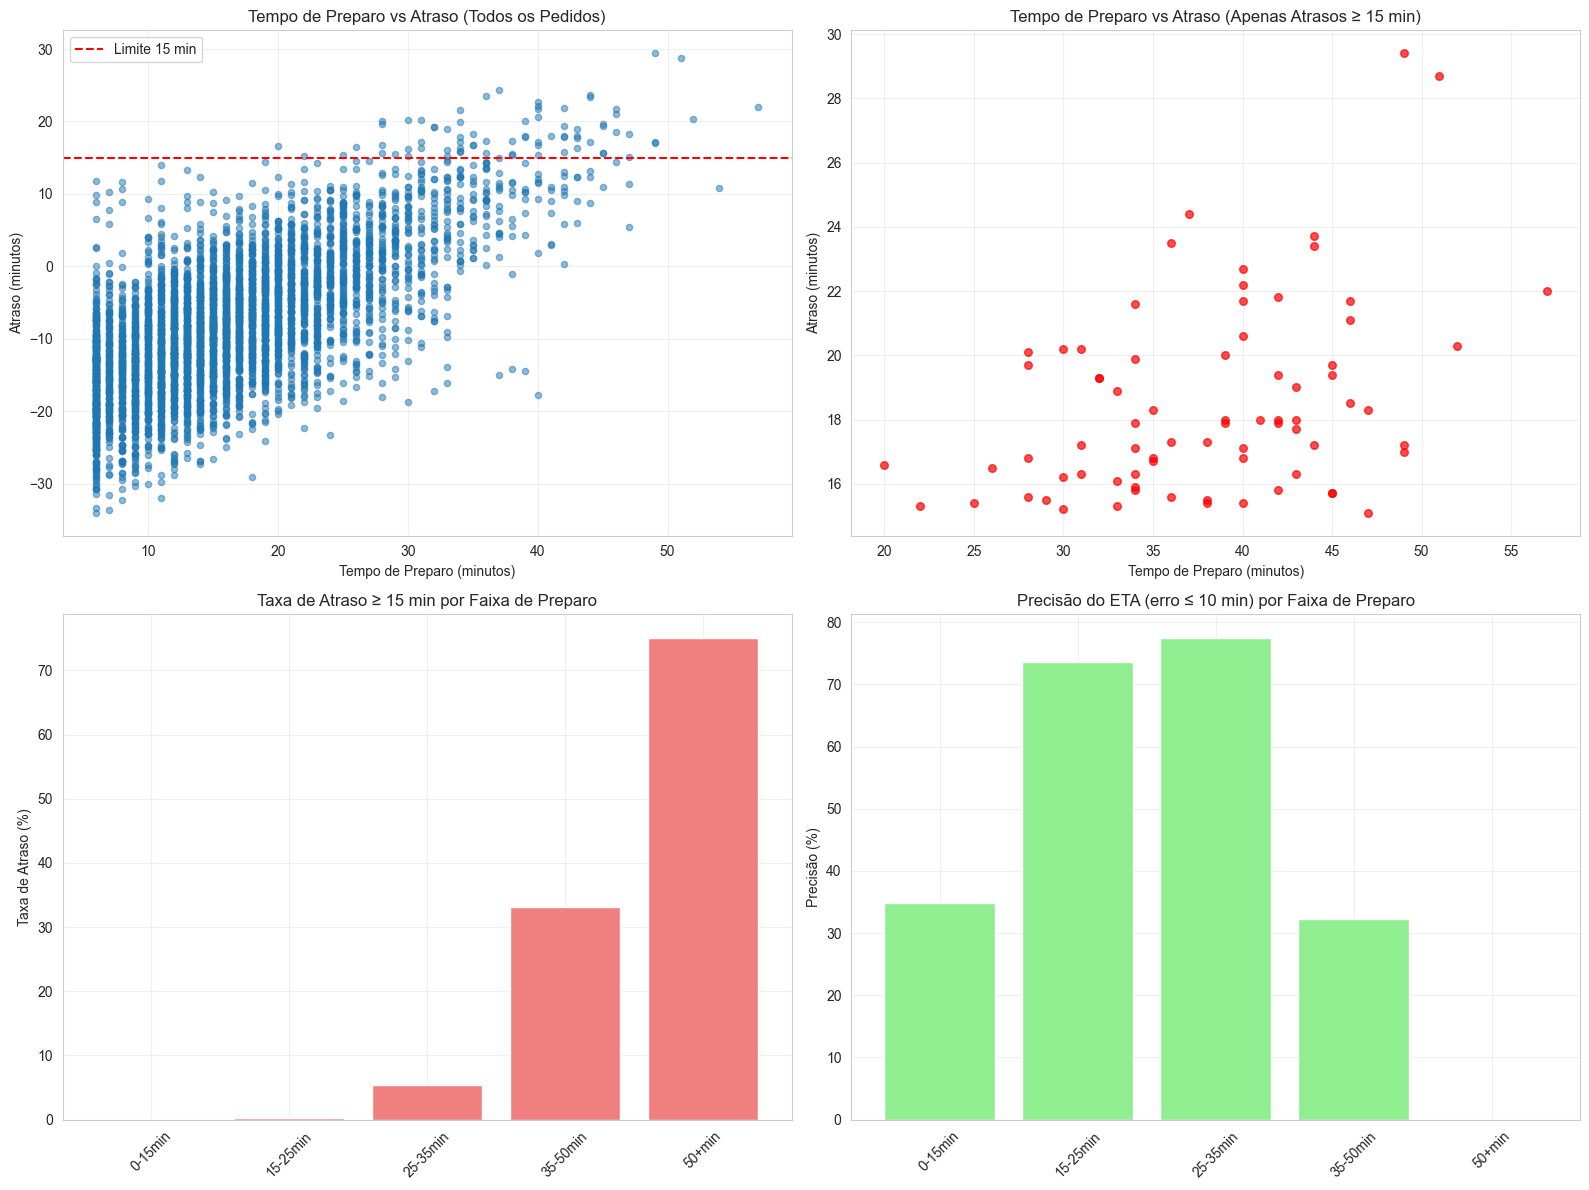

In [68]:
#visualização da relação tempo de preparo vs atrasos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# scatter plot: Tempo de preparo vs Atraso
axes[0,0].scatter(df['tempo_preparo_minutos'], df['atraso_minutos'], alpha=0.5, s=20)
axes[0,0].axhline(y=15, color='red', linestyle='--', label='Limite 15 min')
axes[0,0].set_title('Tempo de Preparo vs Atraso (Todos os Pedidos)')
axes[0,0].set_xlabel('Tempo de Preparo (minutos)')
axes[0,0].set_ylabel('Atraso (minutos)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# scatter plot: Foco nos atrasos grandes
axes[0,1].scatter(df_atraso_15_plus['tempo_preparo_minutos'], df_atraso_15_plus['atraso_minutos'], 
                 alpha=0.7, s=30, color='red')
axes[0,1].set_title('Tempo de Preparo vs Atraso (Apenas Atrasos ≥ 15 min)')
axes[0,1].set_xlabel('Tempo de Preparo (minutos)')
axes[0,1].set_ylabel('Atraso (minutos)')
axes[0,1].grid(True, alpha=0.3)

# t axa de atraso por faixa de preparo
faixas = ['0-15min', '15-25min', '25-35min', '35-50min', '50+min']
taxas_atraso = []
for faixa in faixas:
    df_faixa = df[df['faixa_preparo_geral'] == faixa]
    if len(df_faixa) > 0:
        taxa = len(df_faixa[df_faixa['atraso_minutos'] >= 15]) / len(df_faixa) * 100
        taxas_atraso.append(taxa)
    else:
        taxas_atraso.append(0)

axes[1,0].bar(faixas, taxas_atraso, color='lightcoral')
axes[1,0].set_title('Taxa de Atraso ≥ 15 min por Faixa de Preparo')
axes[1,0].set_ylabel('Taxa de Atraso (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# pprecisão do ETA por faixa de preparo
precisoes = []
for faixa in faixas:
    df_faixa = df[df['faixa_preparo_geral'] == faixa]
    if len(df_faixa) > 0:
        precisos = len(df_faixa[abs(df_faixa['atraso_minutos']) <= 10])
        precisao = (precisos / len(df_faixa)) * 100
        precisoes.append(precisao)
    else:
        precisoes.append(0)

axes[1,1].bar(faixas, precisoes, color='lightgreen')
axes[1,1].set_title('Precisão do ETA (erro ≤ 10 min) por Faixa de Preparo')
axes[1,1].set_ylabel('Precisão (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

